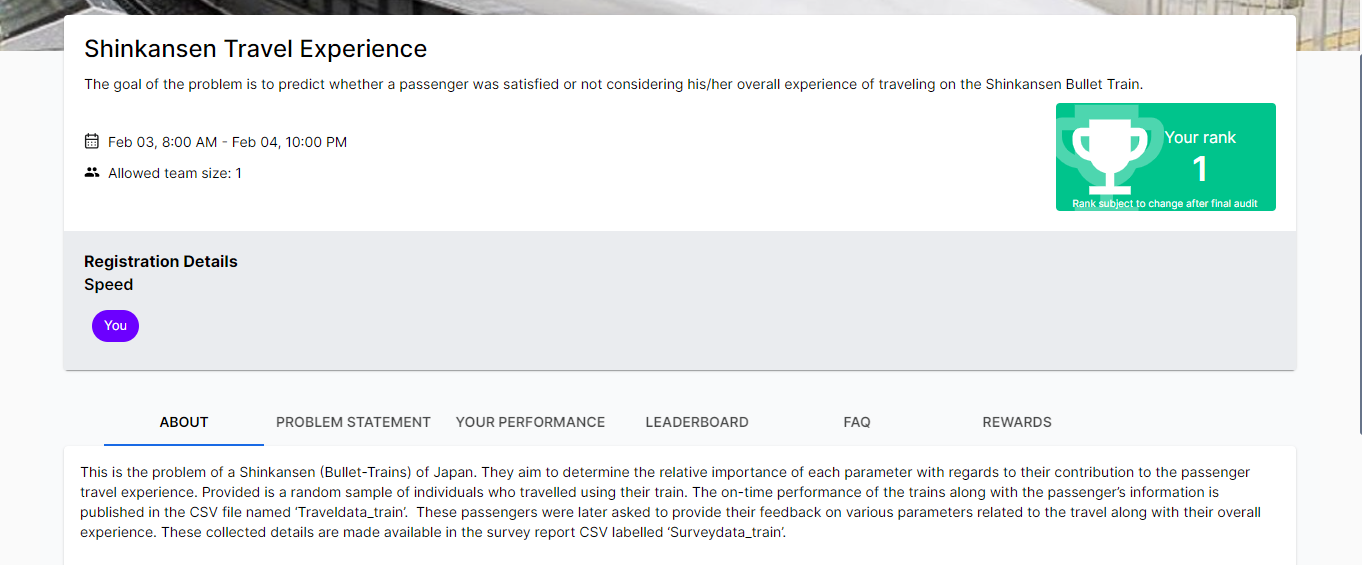
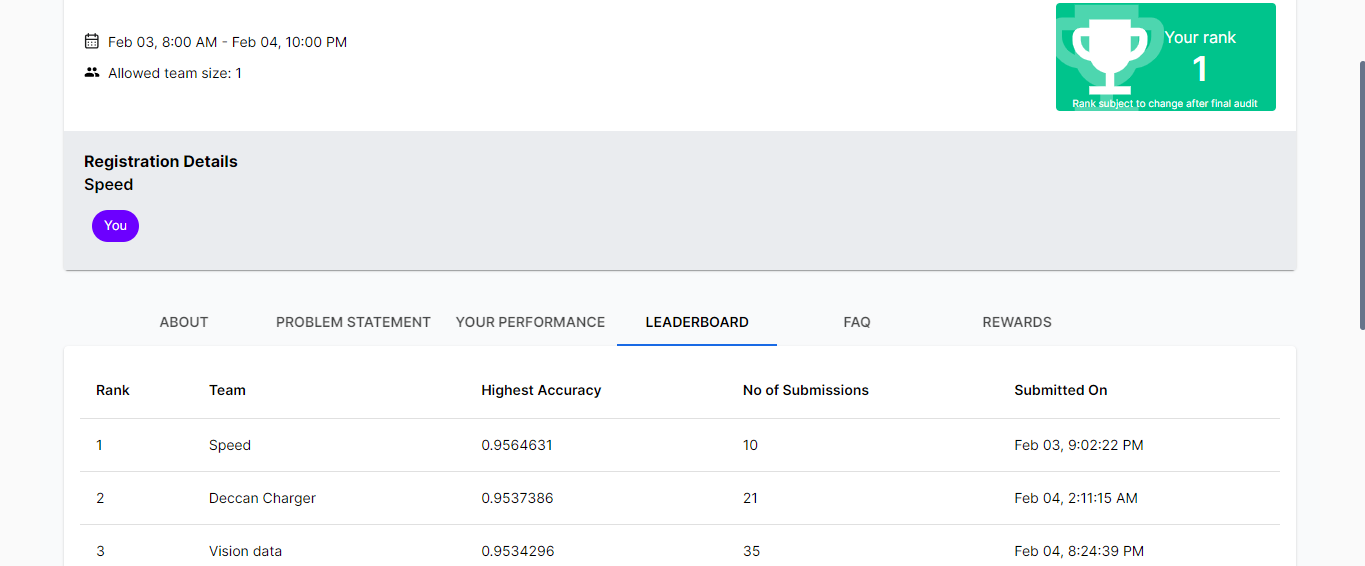


**Objective of the notebook**:

In this notebook, let us explore the given dataset, and also we will build ensemble and RNN models to get started.

**Objective of the competition**:

This is the problem of a Shinkansen (Bullet-Trains) of Japan. They aim to determine the relative importance of each parameter with regards to their contribution to the passenger travel experience. Provided is a random sample of individuals who travelled using their train. The on-time performance of the trains along with the passenger’s information is published in the CSV file named ‘Traveldata_train’.  These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience. These collected details are made available in the survey report CSV labelled ‘Surveydata_train’.

In the survey, a passenger was explicitly asked whether they were delighted with their overall travel experience and that is captured in the data of the survey report under the variable labelled ‘Overall_Experience’. 

The objective of this exercise is to understand which parameters play an important role in swaying passenger feedback towards a positive scale. We have test data containing Travel data and Survey data of passengers. Both the test data and the train data are collected at the same time and belong to the same company.

In [ ]:
!pip install xgboost hyperopt lightgbm catboost optuna -q

In [ ]:
from pandas import read_csv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,ConfusionMatrixDisplay
import statsmodels.api as sm
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, f1_score
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [ ]:
train_data = pd.read_csv('/kaggle/input/shinkansen-travel-experience/Traveldata_train_(1)_(2).csv')
train_sy = pd.read_csv('/kaggle/input/shinkansen-travel-experience/Surveydata_train_(1)_(1).csv')
submission = pd.read_csv('/kaggle/input/shinkansen-travel-experience/Sample_Submission_(2)_(1).csv')
test_data = pd.read_csv('/kaggle/input/shinkansen-travel-experience/Traveldata_test_(1).csv')
test_sy = pd.read_csv('/kaggle/input/shinkansen-travel-experience/Surveydata_test_(1).csv')

In [ ]:
train_data.head()

In [ ]:
train_data.columns[train_data.dtypes=='object']

In [ ]:
train_data.shape

In [ ]:
train_data.describe()

In [ ]:
train_data.info()

In [ ]:
train_data.isnull().sum()

In [ ]:
train_data.isnull().sum().sum()

In [ ]:
for column in train_data.select_dtypes(include='object').columns:
    print(f"Column: {column}")
    print(train_data[column].value_counts())
    print()

In [ ]:
train_data.drop(['ID'],inplace=True, axis=1)

In [ ]:
from sklearn.impute import SimpleImputer

# Numerical columns
numerical_features = train_data.select_dtypes(include=['float64', 'int64']).columns
numerical_imputer = SimpleImputer(strategy='mean')
train_data[numerical_features] = numerical_imputer.fit_transform(train_data[numerical_features])

# Categorical columns
categorical_features = train_data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = categorical_imputer.fit_transform(train_data[categorical_features])

In [ ]:
train_data.isnull().sum()

In [ ]:
train_data.head()

In [ ]:
train_data.info()

In [ ]:
train_data['Age'] = train_data['Age'].astype('int')
train_data['Travel_Distance'] = train_data['Travel_Distance'].astype('int')
train_data['DepartureDelay_in_Mins'] = train_data['DepartureDelay_in_Mins'].astype('int')
train_data['ArrivalDelay_in_Mins'] = train_data['ArrivalDelay_in_Mins'].astype('int')

In [ ]:
train_data.info()

In [ ]:
train_data = pd.get_dummies(train_data, columns=list(train_data.select_dtypes(include=['object']).columns))
train_data.head()

In [ ]:
train_data.shape

In [ ]:
train_sy.shape

In [ ]:
train_sy.head()

In [ ]:
train_sy.describe()

In [ ]:
train_sy.info()

In [ ]:
train_sy.isnull().sum()

In [ ]:
categorical_features = train_sy.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_sy[categorical_features] = categorical_imputer.fit_transform(train_sy[categorical_features])

In [ ]:
train_sy.drop(['ID'],axis=1,inplace=True)

In [ ]:
train_sy = pd.get_dummies(train_sy, columns=list(train_sy.select_dtypes(include=['object']).columns))
train_sy.head()

In [ ]:
train_sy.info()

In [ ]:
overall_experience_col = train_sy.pop('Overall_Experience')
train_sy['Overall_Experience'] = overall_experience_col

In [ ]:
train_sy.shape

In [ ]:
train_df = pd.concat([train_data, train_sy], axis=1)
train_df.shape

In [ ]:
train_df.columns

In [ ]:
train_df.isnull().sum().sum()

In [ ]:
train_df.info()

In [ ]:
train_df.select_dtypes(include=['int64']).columns

In [ ]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

columns_to_remove_outliers = ['Travel_Distance', 'DepartureDelay_in_Mins','ArrivalDelay_in_Mins']

for column in columns_to_remove_outliers:
    train_df_imputed = remove_outliers_iqr(train_df, column)

In [ ]:
train_df_imputed.shape

In [ ]:
train_df_imputed.head()

In [ ]:
X = train_df_imputed.drop(['Overall_Experience'], axis=1)
y = train_df_imputed['Overall_Experience']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    cv_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=make_scorer(f1_score)).mean()

    return cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params

final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)

predictions = final_model.predict(X_test_scaled)

test_score = f1_score(y_test, predictions)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
train_df.to_csv('/kaggle/input/shinkansen-travel-experience/train.csv')
train_df_imputed.to_csv('/kaggle/input/shinkansen-travel-experience/train_outlier.csv')

In [ ]:
KNN_model=KNeighborsClassifier()
KNN_model.fit(X_train_scaled, y_train)
pred_class_test = KNN_model.predict(X_test)
accuracy = accuracy_score(y_test, pred_class_test)
accuracy

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)
    max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt'])
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5)
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=15)

best_model = RandomForestClassifier(random_state=42, **study.best_params)
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

predictions = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
def objective(params):
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
    )

    # Use cross-validation to estimate the model's performance
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=5, scoring="neg_log_loss")

    # Hyperopt aims to minimize the objective function, so negate the scores
    return -scores.mean()

# Define the hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'max_depth': hp.choice('max_depth', range(1, 15)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'subsample': hp.uniform('subsample', 0.5, 1),
}

# Run the hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)

clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    **best
)

clf.fit(X_train_scaled, y_train)
predictions = clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
def objective(params):
    clfx = catboost.CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=0,
    )

    # Use cross-validation to estimate the model's performance
    scores = cross_val_score(clfx, X_train_scaled, y_train, cv=5, scoring="neg_log_loss")

    # Hyperopt aims to minimize the objective function, so negate the scores
    return -scores.mean()

# Define the hyperparameter search space
space = {
    'iterations': hp.choice('iterations', range(100, 1000)),
    'depth': hp.choice('depth', range(1, 12)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
}

# Run the hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)
clf1 = catboost.CatBoostClassifier(
    verbose=0,
    **best
)

clf1.fit(X_scaled, y)
predictions = clf1.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
X_test_scaled.shape

In [ ]:
best_params = {'n_estimators': 500, 'max_features': 'auto', 'max_depth': 110, 'min_samples_split': 4, 'min_samples_leaf': 3}
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_scaled, y)
predictions = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
predictions = clf1.predict(X_test_scaled)+clf.predict(X_test_scaled)+best_model.predict(X_test_scaled)
predictions = np.array([int(x) for x in (predictions>0.4)])
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
df=pd.read_csv('/kaggle/input/shinkansen-travel-experience/train.csv',index_col=[0])
X1 = df.drop(['Overall_Experience'], axis=1)
X1_scaled = scaler.fit_transform(X1)
y1 = df['Overall_Experience']
def objective(params):
    clfx = catboost.CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=0,
    )

    # Use cross-validation to estimate the model's performance
    scores = cross_val_score(clfx, X1_scaled, y1, cv=5, scoring="neg_log_loss")

    # Hyperopt aims to minimize the objective function, so negate the scores
    return -scores.mean()

# Define the hyperparameter search space
space = {
    'iterations': hp.choice('iterations', range(100, 1000)),
    'depth': hp.choice('depth', range(1, 12)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
}

# Run the hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)
clf2 = catboost.CatBoostClassifier(
    verbose=0,
    **best
)

clf2.fit(X1_scaled, y1)
predictions = clf2.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:

def objective(params):
    clfx = catboost.CatBoostClassifier(
        iterations=params['iterations'],
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=0,
        loss_function="Logloss",
        task_type="GPU",
        random_seed=432013,
        od_type="Iter",
    )

    # Use cross-validation to estimate the model's performance
    scores = cross_val_score(clfx, X1_scaled, y1, cv=4, scoring="neg_log_loss")

    # Hyperopt aims to minimize the objective function, so negate the scores
    return -scores.mean()

# Define the hyperparameter search space
space = {
    'iterations': hp.choice('iterations', range(100, 1000)),
    'depth': hp.choice('depth', range(1, 12)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
}

# Run the hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)
clf3 = catboost.CatBoostClassifier(
    verbose=0,
    **best,
    task_type="GPU",
    devices='0:1',
    od_type="Iter"
)

clf3.fit(X1_scaled, y1)
predictions = clf3.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 97))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
from keras.optimizers import SGD
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train_scaled, y_train, batch_size = 32, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))

In [ ]:
predictions = model.predict(X_test_scaled)
predictions = (predictions > 0.5)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
from tensorflow.keras.optimizers import Adamax
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model1 = Sequential()

# layers
model1.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 97))
# model1.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
# model1.add(Dropout(0.25))
model1.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dropout(0.3))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model1.compile(optimizer = Adamax(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model1.fit(X_train_scaled, y_train, batch_size = 128, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))

In [ ]:
predictions = model1.predict(X_test_scaled)
predictions = (predictions > 0.5)
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
from tensorflow.keras.optimizers import Adamax, Adagrad, Adam, SGD
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True)

# Initialising the NN
model1 = Sequential()

# layers
model1.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'selu', input_dim = 97))
# model1.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
# model1.add(Dropout(0.25))
model1.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'selu'))
model1.add(Dropout(0.3))
model1.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'selu'))
model1.add(Dropout(0.3))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
model1.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model1.fit(X_train_scaled, y_train, batch_size = 4, epochs = 500,callbacks=[early_stopping], validation_split=0.2)

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))

In [ ]:
predictions = model1.predict(X_test_scaled)
predictions = np.array([int(x[0]) for x in (predictions>0.5)])
accuracy = accuracy_score(y_test, predictions)
accuracy

In [ ]:
test_data.drop(['ID'],axis=1,inplace=True)
test_sy.drop(['ID'],axis=1, inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer

# Numerical columns
numerical_features = test_data.select_dtypes(include=['float64', 'int64']).columns
numerical_imputer = SimpleImputer(strategy='mean')
test_data[numerical_features] = numerical_imputer.fit_transform(test_data[numerical_features])

# Categorical columns
categorical_features = test_data.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
test_data[categorical_features] = categorical_imputer.fit_transform(test_data[categorical_features])

In [ ]:
test_data['Age'] = test_data['Age'].astype('int')
test_data['Travel_Distance'] = test_data['Travel_Distance'].astype('int')
test_data['DepartureDelay_in_Mins'] = test_data['DepartureDelay_in_Mins'].astype('int')
test_data['ArrivalDelay_in_Mins'] = test_data['ArrivalDelay_in_Mins'].astype('int')

In [ ]:
test_data = pd.get_dummies(test_data, columns=list(test_data.select_dtypes(include=['object']).columns))
test_data.head()

In [ ]:
test_data.shape

In [ ]:
categorical_features = test_sy.select_dtypes(include=['object']).columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
test_sy[categorical_features] = categorical_imputer.fit_transform(test_sy[categorical_features])

In [ ]:
test_sy = pd.get_dummies(test_sy, columns=list(test_sy.select_dtypes(include=['object']).columns))
test_sy.head()

In [ ]:
test_sy.info()

In [ ]:
train_columns = set(train_sy.columns)
test_columns = set(test_sy.columns)
column_difference = train_columns.difference(test_columns)
column_difference

In [ ]:
new_columns = {'Checkin_service_extremely poor',
               'Cleanliness_extremely poor',
               'Onboard_service_extremely poor',
               'Online_support_extremely poor',
               'Platform_location_very inconvinient'}

# Add new columns with zeroes
for column in new_columns:
    test_sy[column] = 0

In [ ]:
test_sy.shape

In [ ]:
ordered_col = list(train_sy.columns)[:-1]
test_sy = test_sy[ordered_col]

In [ ]:
test_df = pd.concat([test_data, test_sy], axis=1)
test_df.shape

In [ ]:
columns_test_df = test_df.columns.tolist()
columns_X = X.columns.tolist()

# Check if both have the same order of columns
if columns_test_df == columns_X:
    print("Both dataframes have the same order of columns.")
else:
    print("The order of columns in the dataframes is different.")

In [ ]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_df)
predictions = clf1.predict(test_scaled)

In [ ]:
test_data = pd.read_csv("/kaggle/input/shinkansen-travel-experience/Surveydata_test_(1).csv")
# Create a DataFrame with player_id and corresponding predictions
result_df = pd.DataFrame({'ID': test_data['ID'], 'Overall_Experience': predictions})

# Save the predictions to a CSV file
result_df.to_csv('Submission_cat.csv', index=False)

In [ ]:
result_df.shape

In [ ]:
test_sy.shape

In [ ]:
test_df.to_csv('/kaggle/input/shinkansen-travel-experience/test.csv')